In [10]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
from IPython.core.display import Image, display
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline
from collections import Counter

from sklearn.metrics import classification_report

from keras import models, layers, optimizers
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical 
from tqdm import tqdm
import math
import pickle
import os
from PIL import ImageFile
import time

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
# from keras.callbacks import TensorBoard

In [13]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    """Returns the path and the Label from the folder"""
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 8)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../imgs/crops/train')
test_files, test_targets = load_dataset('../imgs/crops/test')

# load list of dog names
labels = [item[20:-1] for item in sorted(glob("../imgs/crops/train/*/"))]
CLASSES = len(labels)

print("Classes: ")
print(labels)
#proportions
train_prop = np.count_nonzero(train_targets, axis=0) / len(train_targets)
test_prop = np.count_nonzero(test_targets, axis=0) / len(test_targets)

print('\nProportions: \n')
for index, label in enumerate(labels):
    print('{} train: {:.4f}%'.format(label, train_prop[index]*100))
    print('{} test: {:.4f}%'.format(label, test_prop[index]*100))
    print('*********************')

print('\nStatistics about the Dataset:\n')
print('There are %d total chest deseases.' % len(labels))
print('There are %s total chest images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training chest images.' % len(train_files))
print('There are %d test chest images.'% len(test_files))

Classes: 
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

Proportions: 

Atelectasis train: 19.5291%
Atelectasis test: 18.1347%
*********************
Cardiomegaly train: 16.3435%
Cardiomegaly test: 17.0984%
*********************
Effusion train: 16.2050%
Effusion test: 18.1347%
*********************
Infiltrate train: 11.0803%
Infiltrate test: 11.3990%
*********************
Mass train: 7.8947%
Mass test: 7.2539%
*********************
Nodule train: 8.7258%
Nodule test: 8.2902%
*********************
Pneumonia train: 10.9418%
Pneumonia test: 9.8446%
*********************
Pneumothorax train: 9.2798%
Pneumothorax test: 9.8446%
*********************

Statistics about the Dataset:

There are 8 total chest deseases.
There are 915 total chest images.

There are 722 training chest images.
There are 193 test chest images.


In [3]:
train_DENSNET = np.load('bottleneck_features_train.npy')
val_DENSNET = np.load('bottleneck_features_val.npy')
test_DENSNET = np.load('bottleneck_features_test.npy')

In [14]:
# dimensions of our images.  
IMG_WIDTH, IMG_HEIGHT = 100, 100 

# number of epochs to train top model  
EPOCHS = 2  
# batch size used by flow_from_directory and predict_generator  
BATCH_SIZE = 16

In [15]:
train_data_dir = '../imgs/crops/train'
test_data_dir = '../imgs/crops/test'
datagen_top = ImageDataGenerator(rescale=1./255)  

# Train
generator_top_train = datagen_top.flow_from_directory(train_data_dir,  
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),  
                                                 batch_size = BATCH_SIZE,  
                                                 class_mode = 'categorical',  
                                                 shuffle = False)  

nb_train_samples = len(generator_top_train.filenames)  
num_classes = len(generator_top_train.class_indices)  

# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  

# get the class lebels for the training data, in the original order  
train_labels = generator_top_train.classes  

# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  
#------------------------------------------------------------------------------

# Test
generator_top_test = datagen_top.flow_from_directory(test_data_dir,  
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT),  
                                                 batch_size=BATCH_SIZE,  
                                                 class_mode=None,  
                                                 shuffle=False)  

nb_test_samples = len(generator_top_test.filenames)  

test_data = np.load('bottleneck_features_test.npy')  

test_labels = generator_top_test.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 722 images belonging to 8 classes.
Found 193 images belonging to 8 classes.


In [17]:
 train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((720, 3, 3, 1024), (722, 8), (192, 3, 3, 1024), (193, 8))

In [25]:
top_model_weights_path = 'bottleneck_fc_model.h5' 

model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

checkpointer = ModelCheckpoint(filepath='weights.bbox.DENSNET121.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data, train_labels[:720],  
      epochs=100,  
      batch_size=BATCH_SIZE,  
      validation_split=0.1,
        )  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(test_data, test_labels[:192], batch_size=BATCH_SIZE, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))

Train on 648 samples, validate on 72 samples
Epoch 1/30
648/648 [==============================] - ETA: 15s - loss: 2.2687 - acc: 0.12 - ETA: 5s - loss: 3.0504 - acc: 0.1667 - ETA: 4s - loss: 2.7551 - acc: 0.140 - ETA: 3s - loss: 2.7081 - acc: 0.187 - ETA: 2s - loss: 2.5171 - acc: 0.179 - ETA: 2s - loss: 2.3841 - acc: 0.175 - ETA: 1s - loss: 2.3656 - acc: 0.182 - ETA: 1s - loss: 2.2969 - acc: 0.183 - ETA: 1s - loss: 2.2693 - acc: 0.183 - ETA: 1s - loss: 2.2349 - acc: 0.176 - ETA: 1s - loss: 2.2526 - acc: 0.177 - ETA: 1s - loss: 2.2344 - acc: 0.184 - ETA: 1s - loss: 2.2220 - acc: 0.187 - ETA: 1s - loss: 2.2069 - acc: 0.187 - ETA: 1s - loss: 2.1821 - acc: 0.190 - ETA: 0s - loss: 2.1684 - acc: 0.197 - ETA: 0s - loss: 2.2001 - acc: 0.192 - ETA: 0s - loss: 2.1828 - acc: 0.201 - ETA: 0s - loss: 2.1711 - acc: 0.209 - ETA: 0s - loss: 2.1673 - acc: 0.206 - ETA: 0s - loss: 2.1735 - acc: 0.205 - ETA: 0s - loss: 2.1685 - acc: 0.201 - ETA: 0s - loss: 2.1607 - acc: 0.200 - ETA: 0s - loss: 2.1516 - a

648/648 [==============================] - ETA: 1s - loss: 1.5490 - acc: 0.437 - ETA: 1s - loss: 1.5716 - acc: 0.416 - ETA: 1s - loss: 1.7807 - acc: 0.406 - ETA: 1s - loss: 1.7796 - acc: 0.350 - ETA: 1s - loss: 1.7046 - acc: 0.366 - ETA: 1s - loss: 1.9192 - acc: 0.351 - ETA: 1s - loss: 1.8834 - acc: 0.354 - ETA: 1s - loss: 1.9666 - acc: 0.356 - ETA: 1s - loss: 2.0156 - acc: 0.352 - ETA: 1s - loss: 1.9859 - acc: 0.338 - ETA: 1s - loss: 2.0259 - acc: 0.322 - ETA: 1s - loss: 1.9748 - acc: 0.312 - ETA: 1s - loss: 1.9474 - acc: 0.308 - ETA: 1s - loss: 1.9431 - acc: 0.319 - ETA: 1s - loss: 2.0196 - acc: 0.319 - ETA: 1s - loss: 1.9954 - acc: 0.312 - ETA: 1s - loss: 2.0604 - acc: 0.318 - ETA: 1s - loss: 2.0965 - acc: 0.309 - ETA: 1s - loss: 2.0775 - acc: 0.309 - ETA: 1s - loss: 2.0542 - acc: 0.312 - ETA: 0s - loss: 2.0438 - acc: 0.310 - ETA: 0s - loss: 1.9999 - acc: 0.310 - ETA: 0s - loss: 1.9952 - acc: 0.310 - ETA: 0s - loss: 2.0001 - acc: 0.322 - ETA: 0s - loss: 1.9904 - acc: 0.324 - ETA: 0s

648/648 [==============================] - ETA: 2s - loss: 2.4610 - acc: 0.437 - ETA: 1s - loss: 1.8020 - acc: 0.375 - ETA: 1s - loss: 1.7160 - acc: 0.312 - ETA: 1s - loss: 1.6982 - acc: 0.287 - ETA: 1s - loss: 1.7314 - acc: 0.276 - ETA: 1s - loss: 1.8314 - acc: 0.263 - ETA: 1s - loss: 1.8777 - acc: 0.250 - ETA: 1s - loss: 1.8331 - acc: 0.278 - ETA: 1s - loss: 1.8034 - acc: 0.281 - ETA: 1s - loss: 1.8031 - acc: 0.300 - ETA: 1s - loss: 1.7737 - acc: 0.308 - ETA: 1s - loss: 1.8081 - acc: 0.305 - ETA: 1s - loss: 1.7840 - acc: 0.305 - ETA: 0s - loss: 1.7609 - acc: 0.321 - ETA: 0s - loss: 1.7743 - acc: 0.315 - ETA: 0s - loss: 1.7802 - acc: 0.320 - ETA: 0s - loss: 1.8617 - acc: 0.329 - ETA: 0s - loss: 1.8825 - acc: 0.328 - ETA: 0s - loss: 1.8672 - acc: 0.334 - ETA: 0s - loss: 1.8550 - acc: 0.340 - ETA: 0s - loss: 1.8606 - acc: 0.343 - ETA: 0s - loss: 1.8426 - acc: 0.342 - ETA: 0s - loss: 1.8300 - acc: 0.341 - ETA: 0s - loss: 1.8222 - acc: 0.344 - ETA: 0s - loss: 1.8117 - acc: 0.347 - ETA: 0s

648/648 [==============================] - ETA: 2s - loss: 3.5421 - acc: 0.312 - ETA: 2s - loss: 2.4456 - acc: 0.375 - ETA: 2s - loss: 2.0277 - acc: 0.354 - ETA: 1s - loss: 1.9454 - acc: 0.337 - ETA: 1s - loss: 2.0523 - acc: 0.312 - ETA: 1s - loss: 1.9950 - acc: 0.343 - ETA: 1s - loss: 1.9024 - acc: 0.354 - ETA: 1s - loss: 1.8148 - acc: 0.346 - ETA: 1s - loss: 1.7824 - acc: 0.343 - ETA: 1s - loss: 1.7409 - acc: 0.351 - ETA: 1s - loss: 1.7445 - acc: 0.345 - ETA: 1s - loss: 1.7148 - acc: 0.355 - ETA: 1s - loss: 1.7011 - acc: 0.356 - ETA: 1s - loss: 1.7249 - acc: 0.364 - ETA: 1s - loss: 1.7021 - acc: 0.358 - ETA: 1s - loss: 1.7853 - acc: 0.351 - ETA: 0s - loss: 1.7694 - acc: 0.352 - ETA: 0s - loss: 1.7584 - acc: 0.347 - ETA: 0s - loss: 1.7322 - acc: 0.346 - ETA: 0s - loss: 1.7214 - acc: 0.346 - ETA: 0s - loss: 1.6942 - acc: 0.350 - ETA: 0s - loss: 1.6777 - acc: 0.352 - ETA: 0s - loss: 1.6783 - acc: 0.352 - ETA: 0s - loss: 1.6577 - acc: 0.354 - ETA: 0s - loss: 1.6710 - acc: 0.358 - ETA: 0s

648/648 [==============================] - ETA: 1s - loss: 1.9856 - acc: 0.312 - ETA: 1s - loss: 1.3652 - acc: 0.458 - ETA: 1s - loss: 1.3319 - acc: 0.425 - ETA: 1s - loss: 1.2500 - acc: 0.468 - ETA: 1s - loss: 1.2204 - acc: 0.482 - ETA: 1s - loss: 1.1761 - acc: 0.507 - ETA: 1s - loss: 1.3813 - acc: 0.506 - ETA: 1s - loss: 1.3870 - acc: 0.500 - ETA: 1s - loss: 1.4603 - acc: 0.505 - ETA: 1s - loss: 1.4650 - acc: 0.504 - ETA: 1s - loss: 1.4449 - acc: 0.508 - ETA: 1s - loss: 1.4324 - acc: 0.496 - ETA: 1s - loss: 1.4066 - acc: 0.506 - ETA: 1s - loss: 1.4112 - acc: 0.509 - ETA: 1s - loss: 1.3908 - acc: 0.509 - ETA: 0s - loss: 1.3461 - acc: 0.519 - ETA: 0s - loss: 1.4101 - acc: 0.513 - ETA: 0s - loss: 1.4048 - acc: 0.515 - ETA: 0s - loss: 1.4362 - acc: 0.512 - ETA: 0s - loss: 1.4488 - acc: 0.516 - ETA: 0s - loss: 1.4862 - acc: 0.518 - ETA: 0s - loss: 1.4542 - acc: 0.521 - ETA: 0s - loss: 1.4534 - acc: 0.531 - ETA: 0s - loss: 1.5011 - acc: 0.537 - ETA: 0s - loss: 1.5233 - acc: 0.530 - ETA: 0s

192/192 [==============================] - ETA:  - 0s 270us/step
[INFO] accuracy: 18.23%
[INFO] Loss: nan


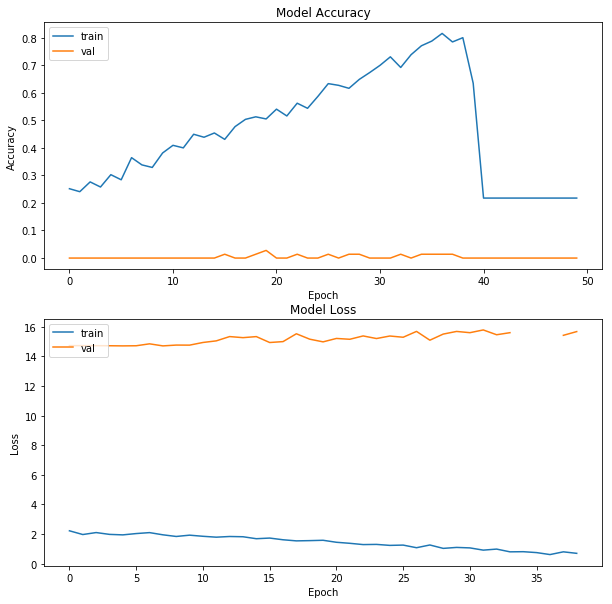

In [24]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

# My Model

In [27]:
# Define the architecture
ChestRESN50_model = Sequential()
ChestRESN50_model.add(Flatten(input_shape=train_data.shape[1:]))
# ChestRESN50_model.add(GlobalAveragePooling2D(input_shape=(train_RESNET.shape[1:])))

ChestRESN50_model.add(layers.Dense(256))
ChestRESN50_model.add(layers.BatchNormalization())
ChestRESN50_model.add(layers.Activation('relu'))
ChestRESN50_model.add(layers.Dropout(0.5))

ChestRESN50_model.add(layers.Dense(CLASSES))
ChestRESN50_model.add(layers.BatchNormalization())
ChestRESN50_model.add(layers.Activation('softmax'))

ChestRESN50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2359552   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 2056      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
__________

In [28]:
# Compile the model
adam = optimizers.Adam(lr=0.0001)
ChestRESN50_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [30]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((720, 3, 3, 1024), (722, 8), (192, 3, 3, 1024), (193, 8))

In [46]:
# Train the model with with the best weights.

# used to save the model that attains the best validation loss
checkpointer = ModelCheckpoint(filepath='weights.bbox.DENSNET121.hdf5', verbose=1, save_best_only=True)

History = ChestRESN50_model.fit(train_data, train_labels[:720], 
          validation_data=(test_data, test_labels[:192]),
          epochs=100, batch_size=BATCH_SIZE, callbacks=[checkpointer], verbose=1, shuffle=False)

Train on 720 samples, validate on 192 samples
Epoch 1/100
720/720 [==============================] - ETA: 2s - loss: 0.3803 - acc: 0.875 - ETA: 2s - loss: 0.3790 - acc: 0.875 - ETA: 2s - loss: 0.3792 - acc: 0.875 - ETA: 2s - loss: 0.3789 - acc: 0.875 - ETA: 2s - loss: 0.3789 - acc: 0.875 - ETA: 2s - loss: 0.3787 - acc: 0.875 - ETA: 2s - loss: 0.3788 - acc: 0.875 - ETA: 1s - loss: 0.3787 - acc: 0.875 - ETA: 1s - loss: 0.3691 - acc: 0.875 - ETA: 1s - loss: 0.3701 - acc: 0.875 - ETA: 1s - loss: 0.3709 - acc: 0.875 - ETA: 1s - loss: 0.3717 - acc: 0.875 - ETA: 1s - loss: 0.3723 - acc: 0.875 - ETA: 1s - loss: 0.3728 - acc: 0.875 - ETA: 1s - loss: 0.3732 - acc: 0.875 - ETA: 1s - loss: 0.3737 - acc: 0.875 - ETA: 1s - loss: 0.3695 - acc: 0.875 - ETA: 1s - loss: 0.3700 - acc: 0.875 - ETA: 1s - loss: 0.3705 - acc: 0.875 - ETA: 1s - loss: 0.3709 - acc: 0.875 - ETA: 1s - loss: 0.3714 - acc: 0.875 - ETA: 1s - loss: 0.3718 - acc: 0.875 - ETA: 1s - loss: 0.3721 - acc: 0.875 - ETA: 1s - loss: 0.3677 - 

720/720 [==============================] - ETA: 2s - loss: 0.3804 - acc: 0.875 - ETA: 2s - loss: 0.3789 - acc: 0.875 - ETA: 2s - loss: 0.3782 - acc: 0.875 - ETA: 2s - loss: 0.3782 - acc: 0.875 - ETA: 2s - loss: 0.3780 - acc: 0.875 - ETA: 2s - loss: 0.3781 - acc: 0.875 - ETA: 2s - loss: 0.3780 - acc: 0.875 - ETA: 2s - loss: 0.3690 - acc: 0.875 - ETA: 2s - loss: 0.3700 - acc: 0.875 - ETA: 1s - loss: 0.3708 - acc: 0.875 - ETA: 1s - loss: 0.3720 - acc: 0.875 - ETA: 1s - loss: 0.3725 - acc: 0.875 - ETA: 1s - loss: 0.3728 - acc: 0.875 - ETA: 1s - loss: 0.3732 - acc: 0.875 - ETA: 1s - loss: 0.3689 - acc: 0.875 - ETA: 1s - loss: 0.3694 - acc: 0.875 - ETA: 1s - loss: 0.3699 - acc: 0.875 - ETA: 1s - loss: 0.3703 - acc: 0.875 - ETA: 1s - loss: 0.3706 - acc: 0.875 - ETA: 1s - loss: 0.3713 - acc: 0.875 - ETA: 1s - loss: 0.3670 - acc: 0.875 - ETA: 1s - loss: 0.3675 - acc: 0.875 - ETA: 1s - loss: 0.3680 - acc: 0.875 - ETA: 1s - loss: 0.3690 - acc: 0.875 - ETA: 0s - loss: 0.3658 - acc: 0.875 - ETA: 0s

720/720 [==============================] - ETA: 2s - loss: 0.3782 - acc: 0.875 - ETA: 2s - loss: 0.3771 - acc: 0.875 - ETA: 2s - loss: 0.3772 - acc: 0.875 - ETA: 2s - loss: 0.3768 - acc: 0.875 - ETA: 2s - loss: 0.3771 - acc: 0.875 - ETA: 2s - loss: 0.3769 - acc: 0.875 - ETA: 2s - loss: 0.3767 - acc: 0.875 - ETA: 2s - loss: 0.3767 - acc: 0.875 - ETA: 2s - loss: 0.3671 - acc: 0.875 - ETA: 2s - loss: 0.3681 - acc: 0.875 - ETA: 2s - loss: 0.3690 - acc: 0.875 - ETA: 1s - loss: 0.3698 - acc: 0.875 - ETA: 1s - loss: 0.3710 - acc: 0.875 - ETA: 1s - loss: 0.3714 - acc: 0.875 - ETA: 1s - loss: 0.3718 - acc: 0.875 - ETA: 1s - loss: 0.3675 - acc: 0.876 - ETA: 1s - loss: 0.3680 - acc: 0.876 - ETA: 1s - loss: 0.3685 - acc: 0.876 - ETA: 1s - loss: 0.3690 - acc: 0.876 - ETA: 1s - loss: 0.3694 - acc: 0.876 - ETA: 1s - loss: 0.3697 - acc: 0.876 - ETA: 1s - loss: 0.3701 - acc: 0.876 - ETA: 1s - loss: 0.3657 - acc: 0.876 - ETA: 1s - loss: 0.3663 - acc: 0.875 - ETA: 1s - loss: 0.3668 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3770 - acc: 0.875 - ETA: 2s - loss: 0.3759 - acc: 0.875 - ETA: 2s - loss: 0.3756 - acc: 0.875 - ETA: 2s - loss: 0.3756 - acc: 0.875 - ETA: 2s - loss: 0.3758 - acc: 0.875 - ETA: 2s - loss: 0.3758 - acc: 0.875 - ETA: 2s - loss: 0.3757 - acc: 0.875 - ETA: 2s - loss: 0.3757 - acc: 0.875 - ETA: 2s - loss: 0.3656 - acc: 0.875 - ETA: 2s - loss: 0.3667 - acc: 0.875 - ETA: 2s - loss: 0.3676 - acc: 0.875 - ETA: 1s - loss: 0.3684 - acc: 0.875 - ETA: 1s - loss: 0.3690 - acc: 0.875 - ETA: 1s - loss: 0.3695 - acc: 0.875 - ETA: 1s - loss: 0.3705 - acc: 0.875 - ETA: 1s - loss: 0.3656 - acc: 0.875 - ETA: 1s - loss: 0.3662 - acc: 0.875 - ETA: 1s - loss: 0.3667 - acc: 0.875 - ETA: 1s - loss: 0.3672 - acc: 0.875 - ETA: 1s - loss: 0.3677 - acc: 0.875 - ETA: 1s - loss: 0.3682 - acc: 0.875 - ETA: 1s - loss: 0.3686 - acc: 0.875 - ETA: 1s - loss: 0.3641 - acc: 0.876 - ETA: 1s - loss: 0.3648 - acc: 0.875 - ETA: 1s - loss: 0.3659 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3763 - acc: 0.875 - ETA: 2s - loss: 0.3753 - acc: 0.875 - ETA: 2s - loss: 0.3751 - acc: 0.875 - ETA: 2s - loss: 0.3749 - acc: 0.875 - ETA: 2s - loss: 0.3748 - acc: 0.875 - ETA: 2s - loss: 0.3748 - acc: 0.875 - ETA: 2s - loss: 0.3748 - acc: 0.875 - ETA: 2s - loss: 0.3749 - acc: 0.875 - ETA: 3s - loss: 0.3648 - acc: 0.875 - ETA: 3s - loss: 0.3659 - acc: 0.875 - ETA: 2s - loss: 0.3669 - acc: 0.875 - ETA: 2s - loss: 0.3676 - acc: 0.875 - ETA: 2s - loss: 0.3682 - acc: 0.875 - ETA: 2s - loss: 0.3688 - acc: 0.875 - ETA: 2s - loss: 0.3693 - acc: 0.875 - ETA: 2s - loss: 0.3697 - acc: 0.875 - ETA: 2s - loss: 0.3652 - acc: 0.875 - ETA: 2s - loss: 0.3658 - acc: 0.875 - ETA: 1s - loss: 0.3663 - acc: 0.875 - ETA: 1s - loss: 0.3668 - acc: 0.875 - ETA: 1s - loss: 0.3677 - acc: 0.875 - ETA: 1s - loss: 0.3680 - acc: 0.875 - ETA: 1s - loss: 0.3635 - acc: 0.875 - ETA: 1s - loss: 0.3642 - acc: 0.875 - ETA: 1s - loss: 0.3647 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 5s - loss: 0.3745 - acc: 0.875 - ETA: 4s - loss: 0.3744 - acc: 0.875 - ETA: 4s - loss: 0.3743 - acc: 0.875 - ETA: 4s - loss: 0.3740 - acc: 0.875 - ETA: 4s - loss: 0.3741 - acc: 0.875 - ETA: 4s - loss: 0.3741 - acc: 0.875 - ETA: 3s - loss: 0.3741 - acc: 0.875 - ETA: 4s - loss: 0.3742 - acc: 0.875 - ETA: 3s - loss: 0.3645 - acc: 0.875 - ETA: 3s - loss: 0.3657 - acc: 0.875 - ETA: 3s - loss: 0.3666 - acc: 0.875 - ETA: 3s - loss: 0.3674 - acc: 0.875 - ETA: 3s - loss: 0.3680 - acc: 0.875 - ETA: 3s - loss: 0.3686 - acc: 0.875 - ETA: 3s - loss: 0.3690 - acc: 0.875 - ETA: 3s - loss: 0.3694 - acc: 0.875 - ETA: 3s - loss: 0.3645 - acc: 0.875 - ETA: 3s - loss: 0.3652 - acc: 0.875 - ETA: 2s - loss: 0.3657 - acc: 0.875 - ETA: 2s - loss: 0.3662 - acc: 0.875 - ETA: 2s - loss: 0.3667 - acc: 0.875 - ETA: 2s - loss: 0.3671 - acc: 0.875 - ETA: 2s - loss: 0.3674 - acc: 0.875 - ETA: 2s - loss: 0.3630 - acc: 0.875 - ETA: 2s - loss: 0.3636 - acc: 0.875 - ETA: 2s

720/720 [==============================] - ETA: 2s - loss: 0.3741 - acc: 0.875 - ETA: 3s - loss: 0.3741 - acc: 0.875 - ETA: 3s - loss: 0.3738 - acc: 0.875 - ETA: 3s - loss: 0.3737 - acc: 0.875 - ETA: 2s - loss: 0.3738 - acc: 0.875 - ETA: 2s - loss: 0.3736 - acc: 0.875 - ETA: 2s - loss: 0.3735 - acc: 0.875 - ETA: 2s - loss: 0.3735 - acc: 0.875 - ETA: 2s - loss: 0.3633 - acc: 0.875 - ETA: 2s - loss: 0.3645 - acc: 0.875 - ETA: 2s - loss: 0.3654 - acc: 0.875 - ETA: 2s - loss: 0.3663 - acc: 0.875 - ETA: 2s - loss: 0.3670 - acc: 0.875 - ETA: 2s - loss: 0.3676 - acc: 0.875 - ETA: 1s - loss: 0.3686 - acc: 0.875 - ETA: 1s - loss: 0.3638 - acc: 0.875 - ETA: 1s - loss: 0.3644 - acc: 0.875 - ETA: 1s - loss: 0.3650 - acc: 0.875 - ETA: 1s - loss: 0.3655 - acc: 0.875 - ETA: 1s - loss: 0.3659 - acc: 0.875 - ETA: 1s - loss: 0.3663 - acc: 0.875 - ETA: 1s - loss: 0.3667 - acc: 0.875 - ETA: 1s - loss: 0.3622 - acc: 0.876 - ETA: 1s - loss: 0.3629 - acc: 0.875 - ETA: 1s - loss: 0.3636 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 3s - loss: 0.3741 - acc: 0.875 - ETA: 2s - loss: 0.3736 - acc: 0.875 - ETA: 2s - loss: 0.3733 - acc: 0.875 - ETA: 2s - loss: 0.3732 - acc: 0.875 - ETA: 2s - loss: 0.3731 - acc: 0.875 - ETA: 2s - loss: 0.3731 - acc: 0.875 - ETA: 2s - loss: 0.3730 - acc: 0.875 - ETA: 2s - loss: 0.3730 - acc: 0.875 - ETA: 2s - loss: 0.3630 - acc: 0.875 - ETA: 2s - loss: 0.3641 - acc: 0.875 - ETA: 2s - loss: 0.3651 - acc: 0.875 - ETA: 2s - loss: 0.3659 - acc: 0.875 - ETA: 2s - loss: 0.3666 - acc: 0.875 - ETA: 2s - loss: 0.3672 - acc: 0.875 - ETA: 1s - loss: 0.3677 - acc: 0.875 - ETA: 1s - loss: 0.3681 - acc: 0.875 - ETA: 1s - loss: 0.3632 - acc: 0.875 - ETA: 1s - loss: 0.3639 - acc: 0.875 - ETA: 1s - loss: 0.3645 - acc: 0.875 - ETA: 1s - loss: 0.3651 - acc: 0.875 - ETA: 1s - loss: 0.3655 - acc: 0.875 - ETA: 1s - loss: 0.3659 - acc: 0.875 - ETA: 1s - loss: 0.3663 - acc: 0.875 - ETA: 1s - loss: 0.3617 - acc: 0.876 - ETA: 1s - loss: 0.3625 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 3s - loss: 0.3733 - acc: 0.875 - ETA: 2s - loss: 0.3727 - acc: 0.875 - ETA: 2s - loss: 0.3726 - acc: 0.875 - ETA: 2s - loss: 0.3725 - acc: 0.875 - ETA: 2s - loss: 0.3724 - acc: 0.875 - ETA: 2s - loss: 0.3724 - acc: 0.875 - ETA: 2s - loss: 0.3724 - acc: 0.875 - ETA: 2s - loss: 0.3724 - acc: 0.875 - ETA: 2s - loss: 0.3625 - acc: 0.875 - ETA: 2s - loss: 0.3637 - acc: 0.875 - ETA: 2s - loss: 0.3647 - acc: 0.875 - ETA: 2s - loss: 0.3655 - acc: 0.875 - ETA: 1s - loss: 0.3662 - acc: 0.875 - ETA: 1s - loss: 0.3668 - acc: 0.875 - ETA: 1s - loss: 0.3673 - acc: 0.875 - ETA: 1s - loss: 0.3677 - acc: 0.875 - ETA: 1s - loss: 0.3630 - acc: 0.875 - ETA: 1s - loss: 0.3636 - acc: 0.875 - ETA: 1s - loss: 0.3642 - acc: 0.875 - ETA: 1s - loss: 0.3647 - acc: 0.875 - ETA: 1s - loss: 0.3651 - acc: 0.875 - ETA: 1s - loss: 0.3655 - acc: 0.875 - ETA: 1s - loss: 0.3659 - acc: 0.875 - ETA: 1s - loss: 0.3620 - acc: 0.875 - ETA: 1s - loss: 0.3626 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3725 - acc: 0.875 - ETA: 2s - loss: 0.3721 - acc: 0.875 - ETA: 2s - loss: 0.3718 - acc: 0.875 - ETA: 2s - loss: 0.3718 - acc: 0.875 - ETA: 2s - loss: 0.3718 - acc: 0.875 - ETA: 2s - loss: 0.3720 - acc: 0.875 - ETA: 2s - loss: 0.3718 - acc: 0.875 - ETA: 2s - loss: 0.3718 - acc: 0.875 - ETA: 2s - loss: 0.3621 - acc: 0.875 - ETA: 2s - loss: 0.3633 - acc: 0.875 - ETA: 2s - loss: 0.3643 - acc: 0.875 - ETA: 2s - loss: 0.3651 - acc: 0.875 - ETA: 2s - loss: 0.3658 - acc: 0.875 - ETA: 1s - loss: 0.3664 - acc: 0.875 - ETA: 1s - loss: 0.3669 - acc: 0.875 - ETA: 1s - loss: 0.3673 - acc: 0.875 - ETA: 1s - loss: 0.3627 - acc: 0.875 - ETA: 1s - loss: 0.3633 - acc: 0.875 - ETA: 1s - loss: 0.3639 - acc: 0.875 - ETA: 1s - loss: 0.3644 - acc: 0.875 - ETA: 1s - loss: 0.3649 - acc: 0.875 - ETA: 1s - loss: 0.3653 - acc: 0.875 - ETA: 1s - loss: 0.3656 - acc: 0.875 - ETA: 1s - loss: 0.3612 - acc: 0.875 - ETA: 1s - loss: 0.3619 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3726 - acc: 0.875 - ETA: 2s - loss: 0.3719 - acc: 0.875 - ETA: 2s - loss: 0.3717 - acc: 0.875 - ETA: 2s - loss: 0.3715 - acc: 0.875 - ETA: 2s - loss: 0.3713 - acc: 0.875 - ETA: 2s - loss: 0.3713 - acc: 0.875 - ETA: 2s - loss: 0.3713 - acc: 0.875 - ETA: 2s - loss: 0.3713 - acc: 0.875 - ETA: 2s - loss: 0.3611 - acc: 0.875 - ETA: 2s - loss: 0.3624 - acc: 0.875 - ETA: 2s - loss: 0.3634 - acc: 0.875 - ETA: 2s - loss: 0.3643 - acc: 0.875 - ETA: 1s - loss: 0.3650 - acc: 0.875 - ETA: 1s - loss: 0.3657 - acc: 0.875 - ETA: 1s - loss: 0.3662 - acc: 0.875 - ETA: 1s - loss: 0.3667 - acc: 0.875 - ETA: 1s - loss: 0.3620 - acc: 0.875 - ETA: 1s - loss: 0.3626 - acc: 0.875 - ETA: 1s - loss: 0.3632 - acc: 0.875 - ETA: 1s - loss: 0.3637 - acc: 0.875 - ETA: 1s - loss: 0.3642 - acc: 0.875 - ETA: 1s - loss: 0.3646 - acc: 0.875 - ETA: 1s - loss: 0.3650 - acc: 0.875 - ETA: 1s - loss: 0.3603 - acc: 0.875 - ETA: 1s - loss: 0.3611 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3711 - acc: 0.875 - ETA: 2s - loss: 0.3708 - acc: 0.875 - ETA: 2s - loss: 0.3707 - acc: 0.875 - ETA: 2s - loss: 0.3707 - acc: 0.875 - ETA: 2s - loss: 0.3705 - acc: 0.875 - ETA: 2s - loss: 0.3704 - acc: 0.875 - ETA: 2s - loss: 0.3704 - acc: 0.875 - ETA: 2s - loss: 0.3705 - acc: 0.875 - ETA: 2s - loss: 0.3602 - acc: 0.875 - ETA: 2s - loss: 0.3616 - acc: 0.875 - ETA: 2s - loss: 0.3626 - acc: 0.875 - ETA: 2s - loss: 0.3635 - acc: 0.875 - ETA: 2s - loss: 0.3642 - acc: 0.875 - ETA: 2s - loss: 0.3649 - acc: 0.875 - ETA: 2s - loss: 0.3655 - acc: 0.875 - ETA: 2s - loss: 0.3660 - acc: 0.875 - ETA: 1s - loss: 0.3611 - acc: 0.875 - ETA: 1s - loss: 0.3617 - acc: 0.875 - ETA: 1s - loss: 0.3623 - acc: 0.875 - ETA: 1s - loss: 0.3629 - acc: 0.875 - ETA: 1s - loss: 0.3634 - acc: 0.875 - ETA: 1s - loss: 0.3638 - acc: 0.875 - ETA: 1s - loss: 0.3643 - acc: 0.875 - ETA: 1s - loss: 0.3596 - acc: 0.875 - ETA: 1s - loss: 0.3604 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3707 - acc: 0.875 - ETA: 2s - loss: 0.3701 - acc: 0.875 - ETA: 2s - loss: 0.3703 - acc: 0.875 - ETA: 3s - loss: 0.3704 - acc: 0.875 - ETA: 3s - loss: 0.3703 - acc: 0.875 - ETA: 3s - loss: 0.3703 - acc: 0.875 - ETA: 3s - loss: 0.3702 - acc: 0.875 - ETA: 3s - loss: 0.3701 - acc: 0.875 - ETA: 3s - loss: 0.3596 - acc: 0.875 - ETA: 3s - loss: 0.3610 - acc: 0.875 - ETA: 2s - loss: 0.3621 - acc: 0.875 - ETA: 2s - loss: 0.3630 - acc: 0.875 - ETA: 2s - loss: 0.3637 - acc: 0.875 - ETA: 2s - loss: 0.3644 - acc: 0.875 - ETA: 2s - loss: 0.3650 - acc: 0.875 - ETA: 2s - loss: 0.3655 - acc: 0.875 - ETA: 2s - loss: 0.3605 - acc: 0.875 - ETA: 2s - loss: 0.3613 - acc: 0.875 - ETA: 2s - loss: 0.3619 - acc: 0.875 - ETA: 2s - loss: 0.3624 - acc: 0.875 - ETA: 2s - loss: 0.3629 - acc: 0.875 - ETA: 1s - loss: 0.3634 - acc: 0.875 - ETA: 1s - loss: 0.3638 - acc: 0.875 - ETA: 1s - loss: 0.3592 - acc: 0.875 - ETA: 1s - loss: 0.3600 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3707 - acc: 0.875 - ETA: 3s - loss: 0.3703 - acc: 0.875 - ETA: 3s - loss: 0.3701 - acc: 0.875 - ETA: 3s - loss: 0.3701 - acc: 0.875 - ETA: 3s - loss: 0.3700 - acc: 0.875 - ETA: 2s - loss: 0.3700 - acc: 0.875 - ETA: 2s - loss: 0.3699 - acc: 0.875 - ETA: 2s - loss: 0.3699 - acc: 0.875 - ETA: 2s - loss: 0.3597 - acc: 0.875 - ETA: 2s - loss: 0.3610 - acc: 0.875 - ETA: 2s - loss: 0.3620 - acc: 0.875 - ETA: 2s - loss: 0.3629 - acc: 0.875 - ETA: 2s - loss: 0.3637 - acc: 0.875 - ETA: 2s - loss: 0.3643 - acc: 0.875 - ETA: 2s - loss: 0.3649 - acc: 0.875 - ETA: 2s - loss: 0.3654 - acc: 0.875 - ETA: 2s - loss: 0.3605 - acc: 0.875 - ETA: 1s - loss: 0.3612 - acc: 0.875 - ETA: 1s - loss: 0.3618 - acc: 0.875 - ETA: 1s - loss: 0.3623 - acc: 0.875 - ETA: 1s - loss: 0.3628 - acc: 0.875 - ETA: 1s - loss: 0.3637 - acc: 0.875 - ETA: 1s - loss: 0.3591 - acc: 0.875 - ETA: 1s - loss: 0.3599 - acc: 0.875 - ETA: 1s - loss: 0.3607 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 3s - loss: 0.3703 - acc: 0.875 - ETA: 3s - loss: 0.3698 - acc: 0.875 - ETA: 3s - loss: 0.3697 - acc: 0.875 - ETA: 3s - loss: 0.3697 - acc: 0.875 - ETA: 3s - loss: 0.3695 - acc: 0.875 - ETA: 3s - loss: 0.3695 - acc: 0.875 - ETA: 2s - loss: 0.3694 - acc: 0.875 - ETA: 2s - loss: 0.3694 - acc: 0.875 - ETA: 2s - loss: 0.3590 - acc: 0.875 - ETA: 2s - loss: 0.3604 - acc: 0.875 - ETA: 2s - loss: 0.3615 - acc: 0.875 - ETA: 2s - loss: 0.3624 - acc: 0.875 - ETA: 2s - loss: 0.3632 - acc: 0.875 - ETA: 2s - loss: 0.3638 - acc: 0.875 - ETA: 2s - loss: 0.3644 - acc: 0.875 - ETA: 2s - loss: 0.3649 - acc: 0.875 - ETA: 2s - loss: 0.3599 - acc: 0.875 - ETA: 1s - loss: 0.3606 - acc: 0.875 - ETA: 1s - loss: 0.3612 - acc: 0.875 - ETA: 1s - loss: 0.3618 - acc: 0.875 - ETA: 1s - loss: 0.3623 - acc: 0.875 - ETA: 1s - loss: 0.3627 - acc: 0.875 - ETA: 1s - loss: 0.3632 - acc: 0.875 - ETA: 1s - loss: 0.3590 - acc: 0.875 - ETA: 1s - loss: 0.3598 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3692 - acc: 0.875 - ETA: 2s - loss: 0.3691 - acc: 0.875 - ETA: 2s - loss: 0.3689 - acc: 0.875 - ETA: 2s - loss: 0.3689 - acc: 0.875 - ETA: 2s - loss: 0.3689 - acc: 0.875 - ETA: 2s - loss: 0.3689 - acc: 0.875 - ETA: 2s - loss: 0.3688 - acc: 0.875 - ETA: 2s - loss: 0.3584 - acc: 0.875 - ETA: 1s - loss: 0.3598 - acc: 0.875 - ETA: 1s - loss: 0.3609 - acc: 0.875 - ETA: 1s - loss: 0.3618 - acc: 0.875 - ETA: 1s - loss: 0.3626 - acc: 0.875 - ETA: 1s - loss: 0.3633 - acc: 0.875 - ETA: 1s - loss: 0.3639 - acc: 0.875 - ETA: 1s - loss: 0.3644 - acc: 0.875 - ETA: 1s - loss: 0.3593 - acc: 0.875 - ETA: 1s - loss: 0.3600 - acc: 0.875 - ETA: 1s - loss: 0.3606 - acc: 0.875 - ETA: 1s - loss: 0.3612 - acc: 0.875 - ETA: 1s - loss: 0.3617 - acc: 0.875 - ETA: 1s - loss: 0.3626 - acc: 0.875 - ETA: 1s - loss: 0.3582 - acc: 0.875 - ETA: 1s - loss: 0.3591 - acc: 0.875 - ETA: 1s - loss: 0.3599 - acc: 0.875 - ETA: 1s - loss: 0.3606 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3688 - acc: 0.875 - ETA: 2s - loss: 0.3683 - acc: 0.875 - ETA: 2s - loss: 0.3683 - acc: 0.875 - ETA: 2s - loss: 0.3683 - acc: 0.875 - ETA: 2s - loss: 0.3682 - acc: 0.875 - ETA: 1s - loss: 0.3681 - acc: 0.875 - ETA: 1s - loss: 0.3578 - acc: 0.876 - ETA: 1s - loss: 0.3592 - acc: 0.876 - ETA: 1s - loss: 0.3603 - acc: 0.876 - ETA: 1s - loss: 0.3613 - acc: 0.876 - ETA: 1s - loss: 0.3621 - acc: 0.876 - ETA: 1s - loss: 0.3629 - acc: 0.876 - ETA: 1s - loss: 0.3635 - acc: 0.876 - ETA: 1s - loss: 0.3640 - acc: 0.876 - ETA: 1s - loss: 0.3593 - acc: 0.876 - ETA: 1s - loss: 0.3600 - acc: 0.876 - ETA: 1s - loss: 0.3612 - acc: 0.876 - ETA: 1s - loss: 0.3617 - acc: 0.876 - ETA: 1s - loss: 0.3621 - acc: 0.876 - ETA: 1s - loss: 0.3625 - acc: 0.876 - ETA: 1s - loss: 0.3579 - acc: 0.876 - ETA: 1s - loss: 0.3595 - acc: 0.875 - ETA: 0s - loss: 0.3603 - acc: 0.875 - ETA: 0s - loss: 0.3609 - acc: 0.875 - ETA: 0s - loss: 0.3584 - acc: 0.876 - ETA: 0s

720/720 [==============================] - ETA: 2s - loss: 0.3677 - acc: 0.875 - ETA: 2s - loss: 0.3676 - acc: 0.875 - ETA: 2s - loss: 0.3675 - acc: 0.875 - ETA: 2s - loss: 0.3675 - acc: 0.875 - ETA: 2s - loss: 0.3674 - acc: 0.875 - ETA: 2s - loss: 0.3674 - acc: 0.875 - ETA: 2s - loss: 0.3674 - acc: 0.875 - ETA: 2s - loss: 0.3579 - acc: 0.875 - ETA: 2s - loss: 0.3592 - acc: 0.875 - ETA: 1s - loss: 0.3603 - acc: 0.875 - ETA: 1s - loss: 0.3612 - acc: 0.875 - ETA: 1s - loss: 0.3620 - acc: 0.875 - ETA: 1s - loss: 0.3627 - acc: 0.875 - ETA: 1s - loss: 0.3633 - acc: 0.875 - ETA: 1s - loss: 0.3638 - acc: 0.875 - ETA: 1s - loss: 0.3587 - acc: 0.875 - ETA: 1s - loss: 0.3594 - acc: 0.875 - ETA: 1s - loss: 0.3600 - acc: 0.875 - ETA: 1s - loss: 0.3606 - acc: 0.875 - ETA: 1s - loss: 0.3611 - acc: 0.875 - ETA: 1s - loss: 0.3616 - acc: 0.875 - ETA: 1s - loss: 0.3620 - acc: 0.875 - ETA: 1s - loss: 0.3574 - acc: 0.875 - ETA: 1s - loss: 0.3583 - acc: 0.875 - ETA: 1s - loss: 0.3591 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3675 - acc: 0.875 - ETA: 2s - loss: 0.3671 - acc: 0.875 - ETA: 2s - loss: 0.3671 - acc: 0.875 - ETA: 2s - loss: 0.3670 - acc: 0.875 - ETA: 2s - loss: 0.3670 - acc: 0.875 - ETA: 2s - loss: 0.3670 - acc: 0.875 - ETA: 1s - loss: 0.3567 - acc: 0.875 - ETA: 1s - loss: 0.3581 - acc: 0.875 - ETA: 1s - loss: 0.3593 - acc: 0.875 - ETA: 1s - loss: 0.3602 - acc: 0.875 - ETA: 1s - loss: 0.3611 - acc: 0.875 - ETA: 1s - loss: 0.3618 - acc: 0.875 - ETA: 1s - loss: 0.3624 - acc: 0.875 - ETA: 1s - loss: 0.3630 - acc: 0.875 - ETA: 1s - loss: 0.3579 - acc: 0.875 - ETA: 1s - loss: 0.3586 - acc: 0.875 - ETA: 1s - loss: 0.3593 - acc: 0.875 - ETA: 1s - loss: 0.3604 - acc: 0.875 - ETA: 1s - loss: 0.3609 - acc: 0.875 - ETA: 1s - loss: 0.3567 - acc: 0.875 - ETA: 1s - loss: 0.3576 - acc: 0.875 - ETA: 1s - loss: 0.3584 - acc: 0.875 - ETA: 0s - loss: 0.3592 - acc: 0.875 - ETA: 0s - loss: 0.3599 - acc: 0.875 - ETA: 0s - loss: 0.3565 - acc: 0.875 - ETA: 0s

720/720 [==============================] - ETA: 2s - loss: 0.3671 - acc: 0.875 - ETA: 2s - loss: 0.3667 - acc: 0.875 - ETA: 2s - loss: 0.3668 - acc: 0.875 - ETA: 2s - loss: 0.3667 - acc: 0.875 - ETA: 2s - loss: 0.3667 - acc: 0.875 - ETA: 2s - loss: 0.3666 - acc: 0.875 - ETA: 2s - loss: 0.3666 - acc: 0.875 - ETA: 2s - loss: 0.3562 - acc: 0.875 - ETA: 1s - loss: 0.3576 - acc: 0.875 - ETA: 1s - loss: 0.3588 - acc: 0.875 - ETA: 1s - loss: 0.3598 - acc: 0.875 - ETA: 1s - loss: 0.3606 - acc: 0.875 - ETA: 1s - loss: 0.3614 - acc: 0.875 - ETA: 1s - loss: 0.3620 - acc: 0.875 - ETA: 1s - loss: 0.3625 - acc: 0.875 - ETA: 1s - loss: 0.3575 - acc: 0.875 - ETA: 1s - loss: 0.3590 - acc: 0.875 - ETA: 1s - loss: 0.3595 - acc: 0.875 - ETA: 1s - loss: 0.3601 - acc: 0.875 - ETA: 1s - loss: 0.3605 - acc: 0.875 - ETA: 1s - loss: 0.3610 - acc: 0.875 - ETA: 1s - loss: 0.3565 - acc: 0.875 - ETA: 1s - loss: 0.3574 - acc: 0.875 - ETA: 1s - loss: 0.3583 - acc: 0.875 - ETA: 1s - loss: 0.3591 - acc: 0.875 - ETA: 0s

720/720 [==============================] - ETA: 2s - loss: 0.3665 - acc: 0.875 - ETA: 2s - loss: 0.3664 - acc: 0.875 - ETA: 2s - loss: 0.3663 - acc: 0.875 - ETA: 2s - loss: 0.3663 - acc: 0.875 - ETA: 2s - loss: 0.3662 - acc: 0.875 - ETA: 2s - loss: 0.3662 - acc: 0.875 - ETA: 2s - loss: 0.3662 - acc: 0.875 - ETA: 1s - loss: 0.3561 - acc: 0.875 - ETA: 1s - loss: 0.3576 - acc: 0.875 - ETA: 1s - loss: 0.3587 - acc: 0.875 - ETA: 1s - loss: 0.3597 - acc: 0.875 - ETA: 1s - loss: 0.3606 - acc: 0.875 - ETA: 1s - loss: 0.3613 - acc: 0.875 - ETA: 1s - loss: 0.3624 - acc: 0.875 - ETA: 1s - loss: 0.3572 - acc: 0.875 - ETA: 1s - loss: 0.3580 - acc: 0.875 - ETA: 1s - loss: 0.3592 - acc: 0.875 - ETA: 1s - loss: 0.3597 - acc: 0.875 - ETA: 1s - loss: 0.3602 - acc: 0.875 - ETA: 1s - loss: 0.3607 - acc: 0.875 - ETA: 1s - loss: 0.3560 - acc: 0.875 - ETA: 1s - loss: 0.3578 - acc: 0.875 - ETA: 0s - loss: 0.3586 - acc: 0.875 - ETA: 0s - loss: 0.3594 - acc: 0.875 - ETA: 0s - loss: 0.3560 - acc: 0.875 - ETA: 0s

720/720 [==============================] - ETA: 2s - loss: 0.3667 - acc: 0.875 - ETA: 2s - loss: 0.3661 - acc: 0.875 - ETA: 2s - loss: 0.3660 - acc: 0.875 - ETA: 2s - loss: 0.3659 - acc: 0.875 - ETA: 2s - loss: 0.3658 - acc: 0.875 - ETA: 2s - loss: 0.3657 - acc: 0.875 - ETA: 2s - loss: 0.3657 - acc: 0.875 - ETA: 2s - loss: 0.3556 - acc: 0.875 - ETA: 1s - loss: 0.3571 - acc: 0.875 - ETA: 1s - loss: 0.3583 - acc: 0.875 - ETA: 1s - loss: 0.3593 - acc: 0.875 - ETA: 1s - loss: 0.3601 - acc: 0.875 - ETA: 1s - loss: 0.3609 - acc: 0.875 - ETA: 1s - loss: 0.3615 - acc: 0.875 - ETA: 1s - loss: 0.3621 - acc: 0.875 - ETA: 1s - loss: 0.3569 - acc: 0.875 - ETA: 1s - loss: 0.3576 - acc: 0.875 - ETA: 1s - loss: 0.3583 - acc: 0.875 - ETA: 1s - loss: 0.3589 - acc: 0.875 - ETA: 1s - loss: 0.3594 - acc: 0.875 - ETA: 1s - loss: 0.3599 - acc: 0.875 - ETA: 1s - loss: 0.3604 - acc: 0.875 - ETA: 1s - loss: 0.3556 - acc: 0.875 - ETA: 1s - loss: 0.3566 - acc: 0.875 - ETA: 1s - loss: 0.3575 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3655 - acc: 0.875 - ETA: 1s - loss: 0.3654 - acc: 0.875 - ETA: 2s - loss: 0.3653 - acc: 0.875 - ETA: 2s - loss: 0.3654 - acc: 0.875 - ETA: 1s - loss: 0.3654 - acc: 0.875 - ETA: 1s - loss: 0.3654 - acc: 0.875 - ETA: 1s - loss: 0.3550 - acc: 0.875 - ETA: 1s - loss: 0.3565 - acc: 0.875 - ETA: 1s - loss: 0.3588 - acc: 0.875 - ETA: 1s - loss: 0.3596 - acc: 0.875 - ETA: 1s - loss: 0.3604 - acc: 0.875 - ETA: 1s - loss: 0.3611 - acc: 0.875 - ETA: 1s - loss: 0.3616 - acc: 0.875 - ETA: 1s - loss: 0.3565 - acc: 0.875 - ETA: 1s - loss: 0.3579 - acc: 0.875 - ETA: 1s - loss: 0.3585 - acc: 0.875 - ETA: 1s - loss: 0.3590 - acc: 0.875 - ETA: 1s - loss: 0.3600 - acc: 0.875 - ETA: 1s - loss: 0.3562 - acc: 0.875 - ETA: 0s - loss: 0.3580 - acc: 0.875 - ETA: 0s - loss: 0.3587 - acc: 0.875 - ETA: 0s - loss: 0.3552 - acc: 0.875 - ETA: 0s - loss: 0.3562 - acc: 0.875 - ETA: 0s - loss: 0.3573 - acc: 0.875 - ETA: 0s - loss: 0.3582 - acc: 0.875 - ETA: 0s

720/720 [==============================] - ETA: 2s - loss: 0.3657 - acc: 0.875 - ETA: 2s - loss: 0.3652 - acc: 0.875 - ETA: 2s - loss: 0.3652 - acc: 0.875 - ETA: 2s - loss: 0.3650 - acc: 0.875 - ETA: 2s - loss: 0.3649 - acc: 0.875 - ETA: 2s - loss: 0.3649 - acc: 0.875 - ETA: 2s - loss: 0.3648 - acc: 0.875 - ETA: 2s - loss: 0.3649 - acc: 0.875 - ETA: 2s - loss: 0.3547 - acc: 0.875 - ETA: 2s - loss: 0.3562 - acc: 0.875 - ETA: 1s - loss: 0.3574 - acc: 0.875 - ETA: 1s - loss: 0.3584 - acc: 0.875 - ETA: 1s - loss: 0.3600 - acc: 0.875 - ETA: 1s - loss: 0.3607 - acc: 0.875 - ETA: 1s - loss: 0.3613 - acc: 0.875 - ETA: 1s - loss: 0.3563 - acc: 0.875 - ETA: 1s - loss: 0.3570 - acc: 0.875 - ETA: 1s - loss: 0.3577 - acc: 0.875 - ETA: 1s - loss: 0.3583 - acc: 0.875 - ETA: 1s - loss: 0.3588 - acc: 0.875 - ETA: 1s - loss: 0.3593 - acc: 0.875 - ETA: 1s - loss: 0.3598 - acc: 0.875 - ETA: 1s - loss: 0.3553 - acc: 0.876 - ETA: 1s - loss: 0.3563 - acc: 0.875 - ETA: 1s - loss: 0.3572 - acc: 0.875 - ETA: 1s

720/720 [==============================] - ETA: 2s - loss: 0.3648 - acc: 0.875 - ETA: 2s - loss: 0.3645 - acc: 0.875 - ETA: 2s - loss: 0.3646 - acc: 0.875 - ETA: 2s - loss: 0.3645 - acc: 0.875 - ETA: 2s - loss: 0.3645 - acc: 0.875 - ETA: 2s - loss: 0.3645 - acc: 0.875 - ETA: 2s - loss: 0.3644 - acc: 0.875 - ETA: 2s - loss: 0.3644 - acc: 0.875 - ETA: 2s - loss: 0.3539 - acc: 0.875 - ETA: 2s - loss: 0.3555 - acc: 0.875 - ETA: 1s - loss: 0.3568 - acc: 0.875 - ETA: 1s - loss: 0.3578 - acc: 0.875 - ETA: 1s - loss: 0.3587 - acc: 0.875 - ETA: 1s - loss: 0.3595 - acc: 0.875 - ETA: 1s - loss: 0.3602 - acc: 0.875 - ETA: 1s - loss: 0.3607 - acc: 0.875 - ETA: 1s - loss: 0.3559 - acc: 0.875 - ETA: 1s - loss: 0.3566 - acc: 0.875 - ETA: 1s - loss: 0.3573 - acc: 0.875 - ETA: 1s - loss: 0.3579 - acc: 0.875 - ETA: 1s - loss: 0.3585 - acc: 0.875 - ETA: 1s - loss: 0.3590 - acc: 0.875 - ETA: 1s - loss: 0.3547 - acc: 0.875 - ETA: 1s - loss: 0.3558 - acc: 0.875 - ETA: 1s - loss: 0.3567 - acc: 0.875 - ETA: 1s

In [34]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((720, 3, 3, 1024), (722, 8), (192, 3, 3, 1024), (193, 8))

In [47]:
### Load the model weights with the best validation loss.
ChestRESN50_model.load_weights('weights.bbox.DENSNET121.hdf5')

### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
predictions = [np.argmax(ChestRESN50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_data]
# predictions = ChestRESN50_model.predict_classes(test_DENSNET)

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_labels[:192], axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 32.8125%


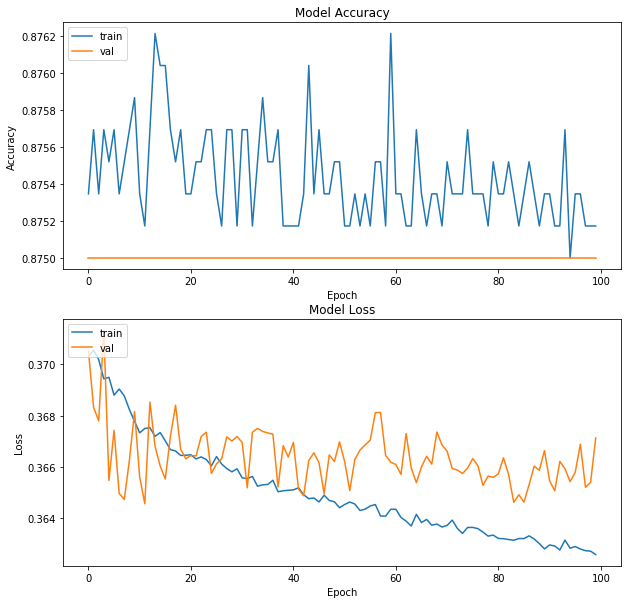

In [48]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(History.history['acc'])  
plt.plot(History.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [49]:
# Classification Report
y_true = np.argmax(test_labels, axis=1)
print(classification_report(y_true[:192], predictions, target_names=labels))

              precision    recall  f1-score   support

 Atelectasis       0.27      0.46      0.34        35
Cardiomegaly       0.65      0.73      0.69        33
    Effusion       0.30      0.37      0.33        35
  Infiltrate       0.32      0.27      0.29        22
        Mass       0.27      0.21      0.24        14
      Nodule       0.00      0.00      0.00        16
   Pneumonia       0.12      0.05      0.07        19
Pneumothorax       0.00      0.00      0.00        18

   micro avg       0.33      0.33      0.33       192
   macro avg       0.24      0.26      0.25       192
weighted avg       0.28      0.33      0.30       192



### Train Predictions

In [31]:
predictions = [np.argmax(ChestRESN50_model.predict(np.expand_dims(feature, axis=0))) for feature in train_DENSNET]

ValueError: Found input variables with inconsistent numbers of samples: [2000, 7260]

In [52]:
y_true = np.argmax(train_targets, axis=1)
print(classification_report(y_true[:2208], predictions, target_names=labels))

              precision    recall  f1-score   support

Infiltration       0.50      0.87      0.63      1109
  No Finding       0.47      0.12      0.19      1099

   micro avg       0.49      0.49      0.49      2208
   macro avg       0.48      0.49      0.41      2208
weighted avg       0.48      0.49      0.41      2208

